In [626]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import seaborn as sns # Import seaborn for better visualizations
import math
from scipy import stats
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [627]:
from utils import line_plot_viz, box_plot_viz, heat_map_viz, hist_plot_viz
import warnings
warnings.filterwarnings('ignore')

In [628]:
og_data = pd.read_csv('./data/bike/hour.csv')
data = og_data.copy()

In [629]:
data.describe()

,index,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,demand
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [630]:
data.dtypes

index           int64
date           object
season          int64
year            int64
month           int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
demand          int64
dtype: object

In [631]:
data.columns


Index(['index', 'date', 'season', 'year', 'month', 'hour', 'holiday',
       'weekday', 'workingday', 'weather', 'temp', 'atemp', 'humidity',
       'windspeed', 'casual', 'registered', 'demand'],
      dtype='object')

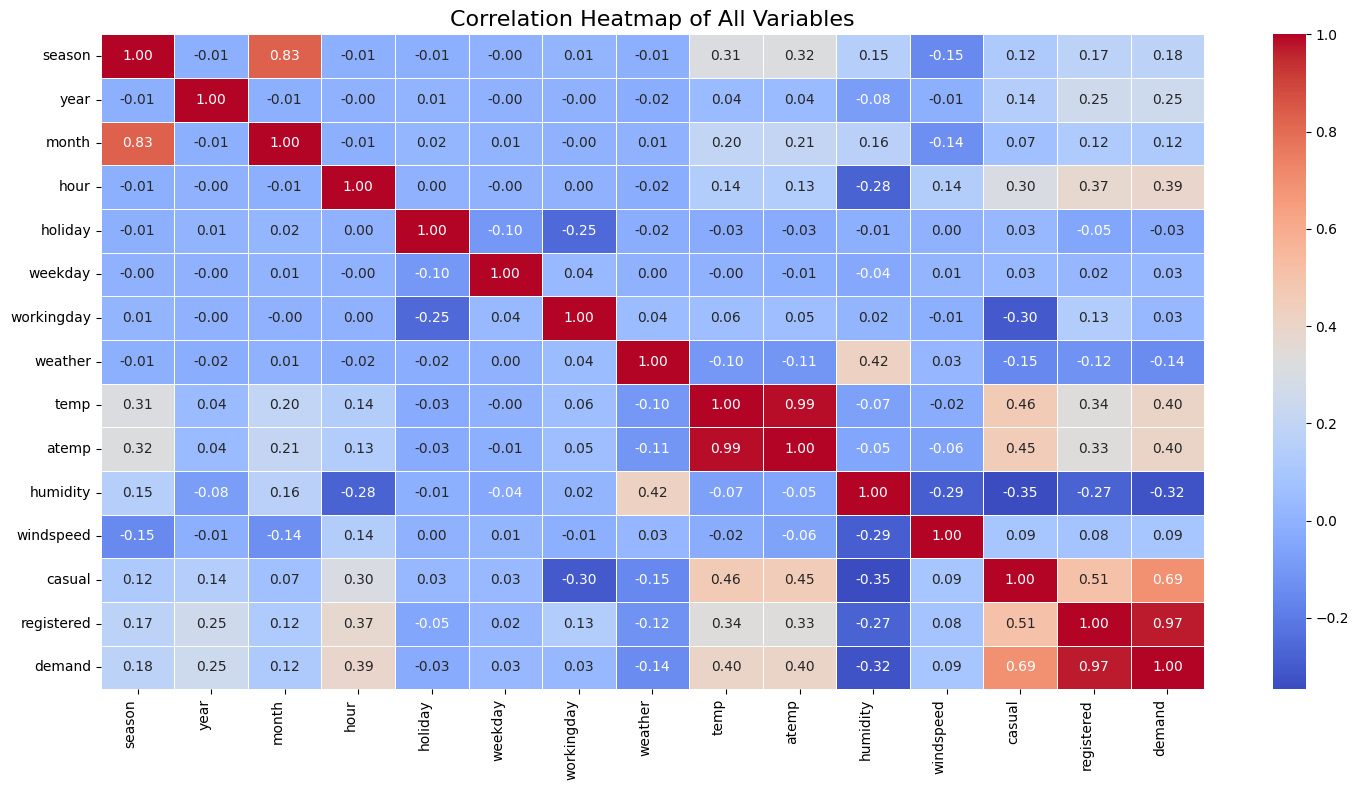

In [632]:
cols_nodate = [ 'season', 'year', 'month', 'hour', 'holiday',
       'weekday', 'workingday', 'weather', 'temp', 'atemp', 'humidity',
       'windspeed', 'casual', 'registered', 'demand']
heat_map_viz(data[cols_nodate])

<Figure size 2000x1000 with 0 Axes>

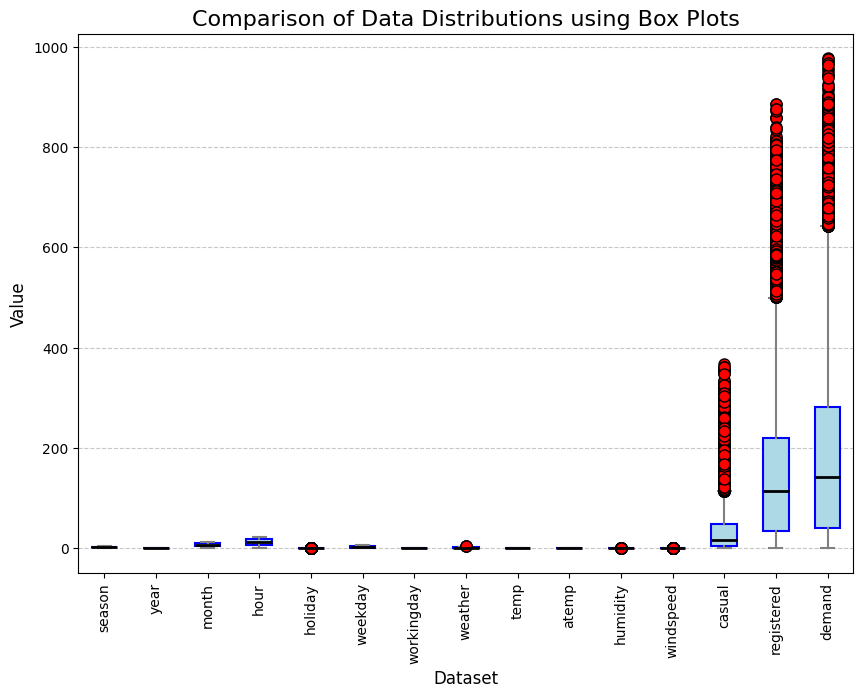

In [633]:
box_plot_viz(data[cols_nodate])

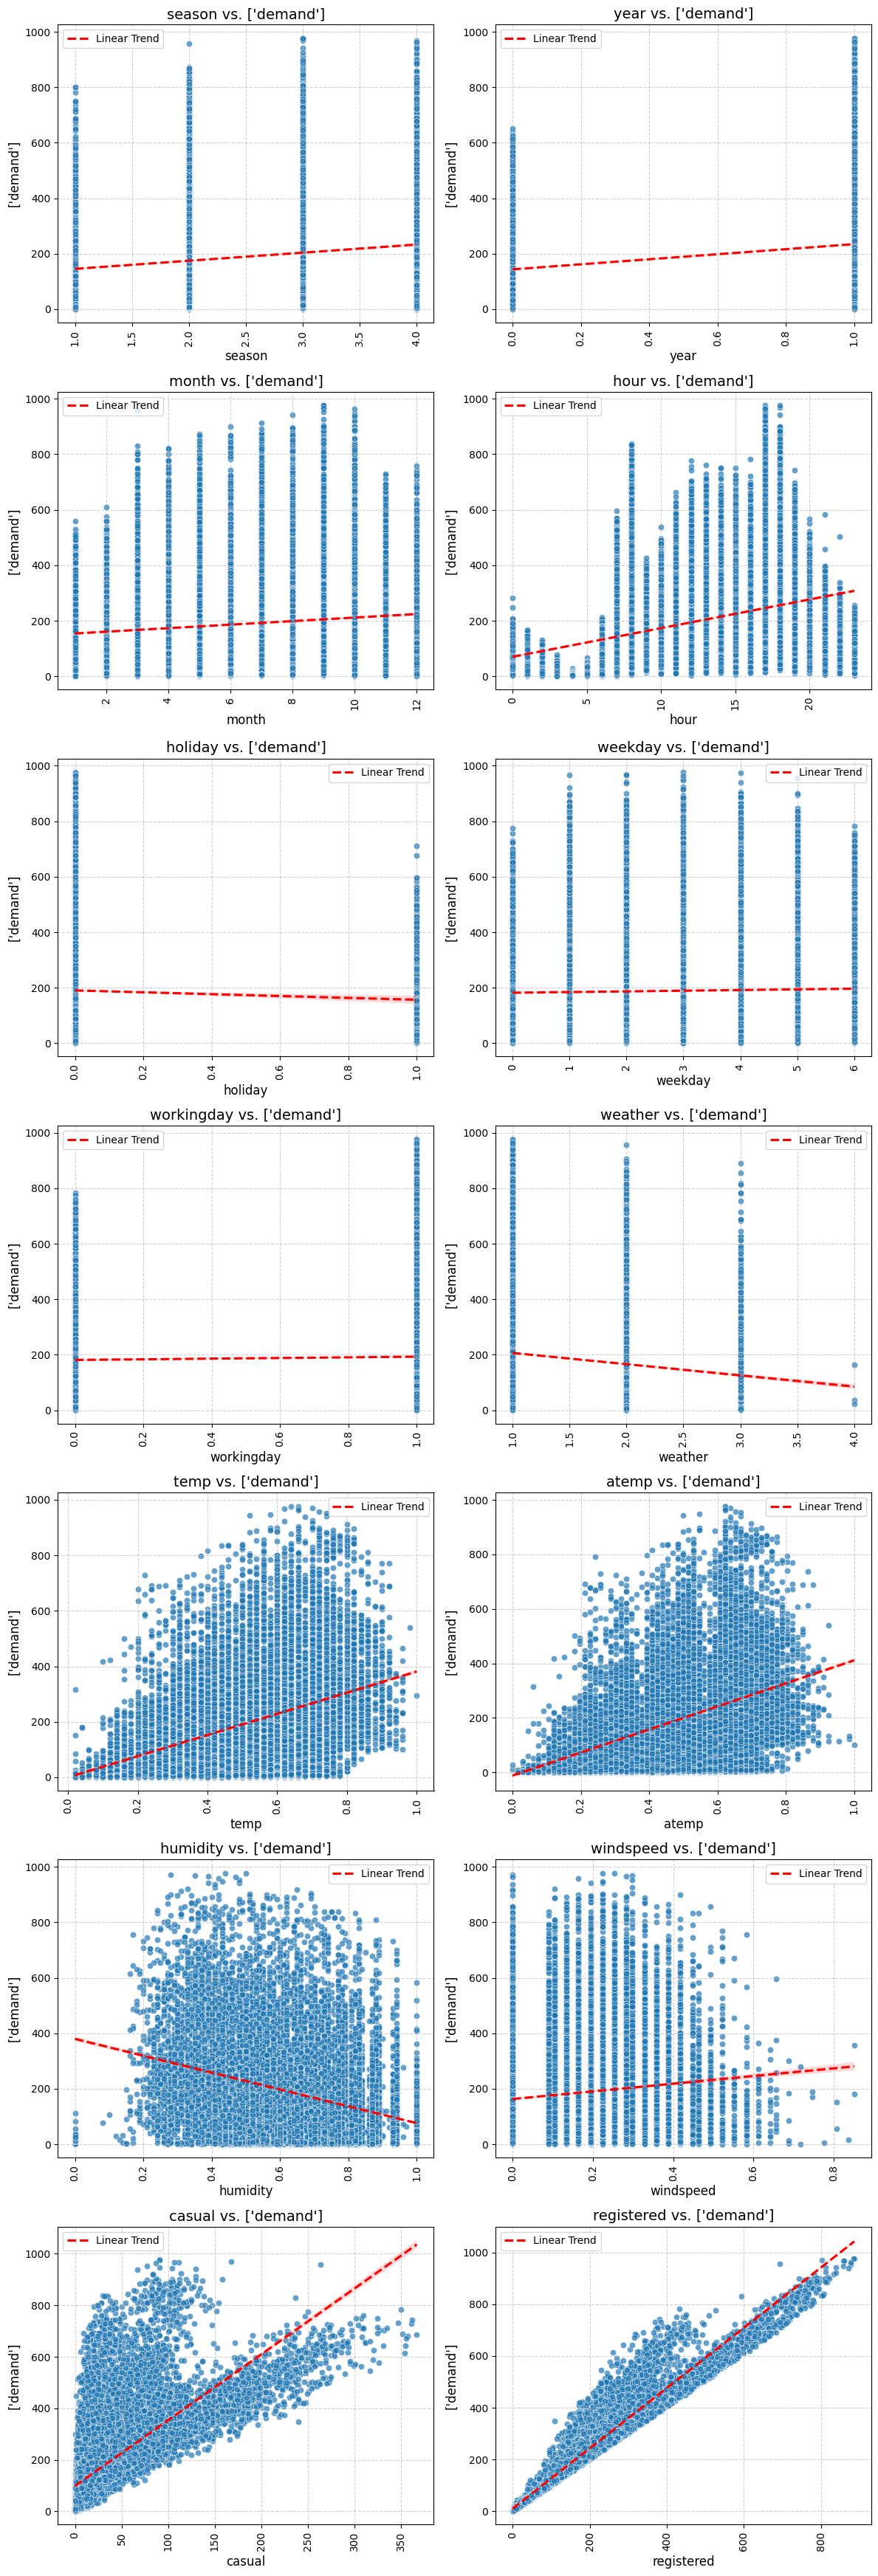

In [634]:
X_cols = [ 'season', 'year', 'month', 'hour', 'holiday',
       'weekday', 'workingday', 'weather', 'temp', 'atemp', 'humidity',
       'windspeed', 'casual', 'registered']
Y_cols = ['demand']

line_plot_viz(X_columns=X_cols, Y_columns=Y_cols, data=data)

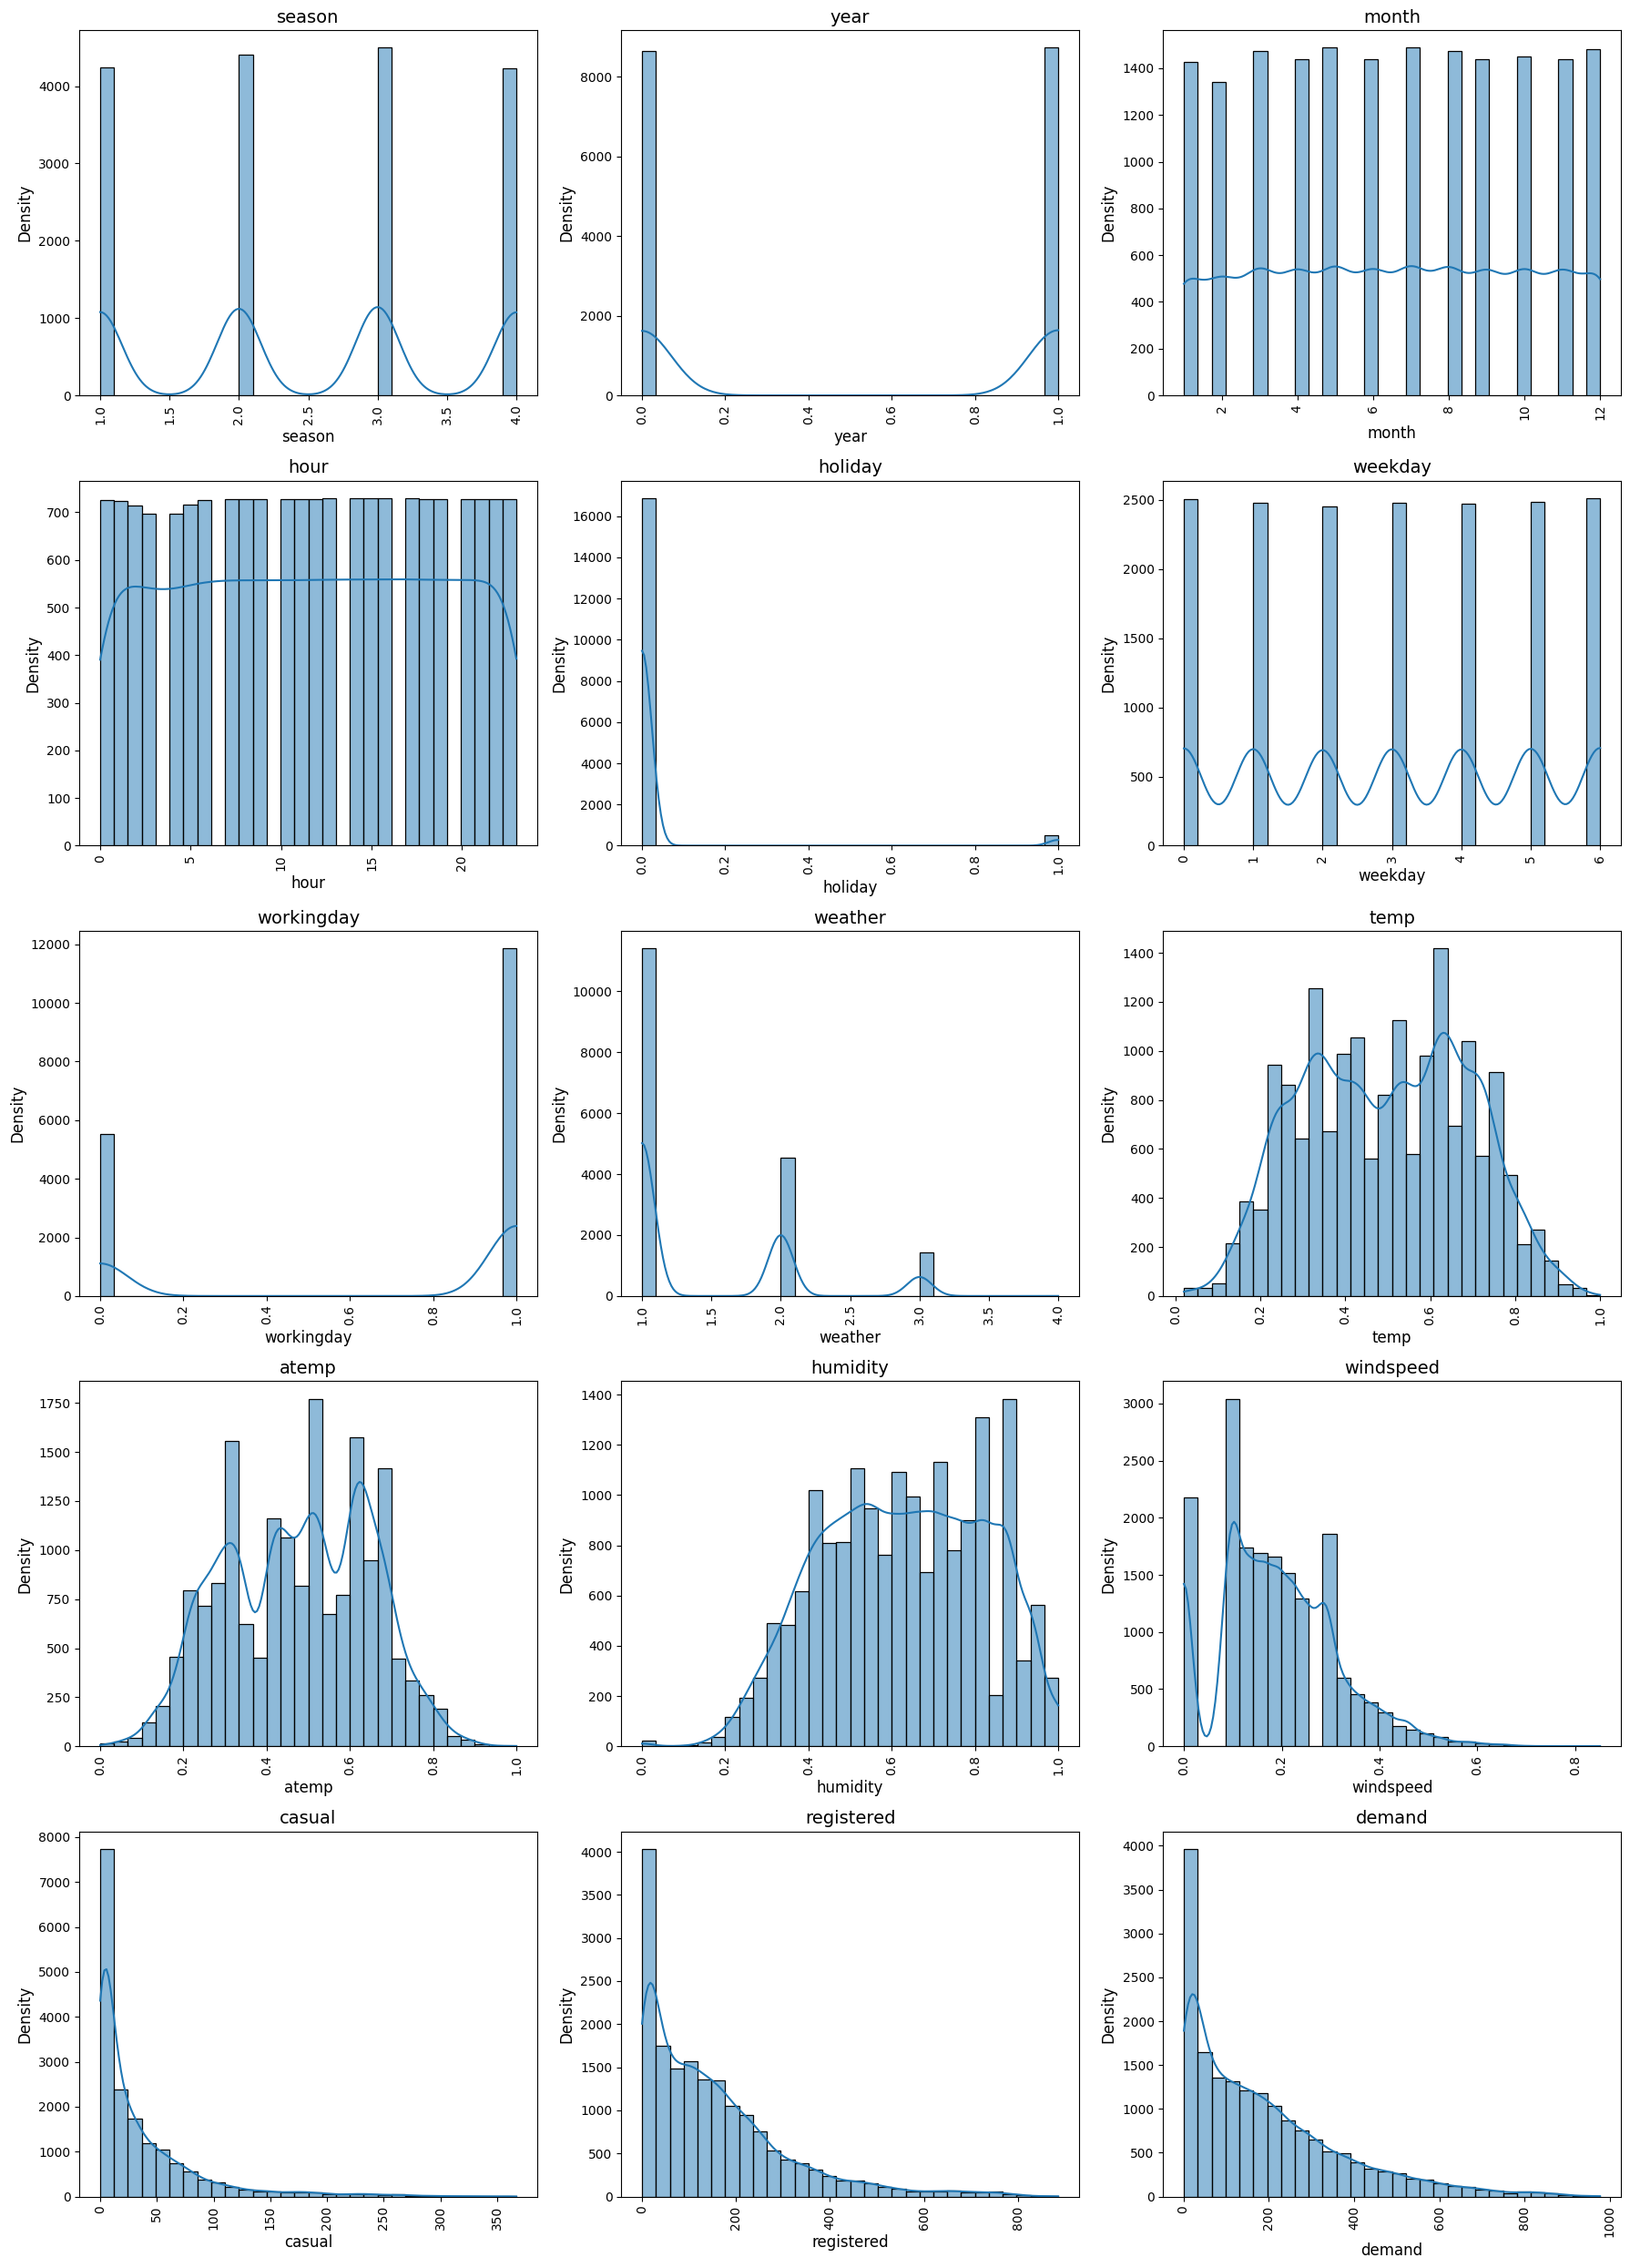

In [635]:
hist_plot_viz(columns=[*X_cols, *Y_cols], data=data)

### Feature Removal
- Remove atemp as it has high multi colinearity with temp
- Remove Year as we only has 2 yrs of data
- Remove casual and registered as the sum of these two is in the demand column which adds multi-colinearity
- Remove Index

In [636]:
cols_to_remove = ['atemp', 'year', 'date', 'casual', 'registered', 'index']
data.drop(columns= cols_to_remove, inplace=True)
current_cols = [x for x in X_cols if x not in cols_to_remove]

### Identify the categorical variables

In [637]:

def convert_to_categorical_dtypes(cat_threshold, cols, proc_data):
    data = proc_data.copy()
    for feature in cols:
        uniq_vals = data[feature].unique()
        if(len(uniq_vals) < cat_threshold):
            data[feature] = data[feature].astype('category')
    print(data[cols].dtypes)
    return data
cat_threshold = 30
data = convert_to_categorical_dtypes(cat_threshold=cat_threshold, cols=current_cols, proc_data=data)

season        category
month         category
hour          category
holiday       category
weekday       category
workingday    category
weather       category
temp           float64
humidity       float64
windspeed      float64
dtype: object


#### For the Categorical variables lets aggregate demand by each category and plot 

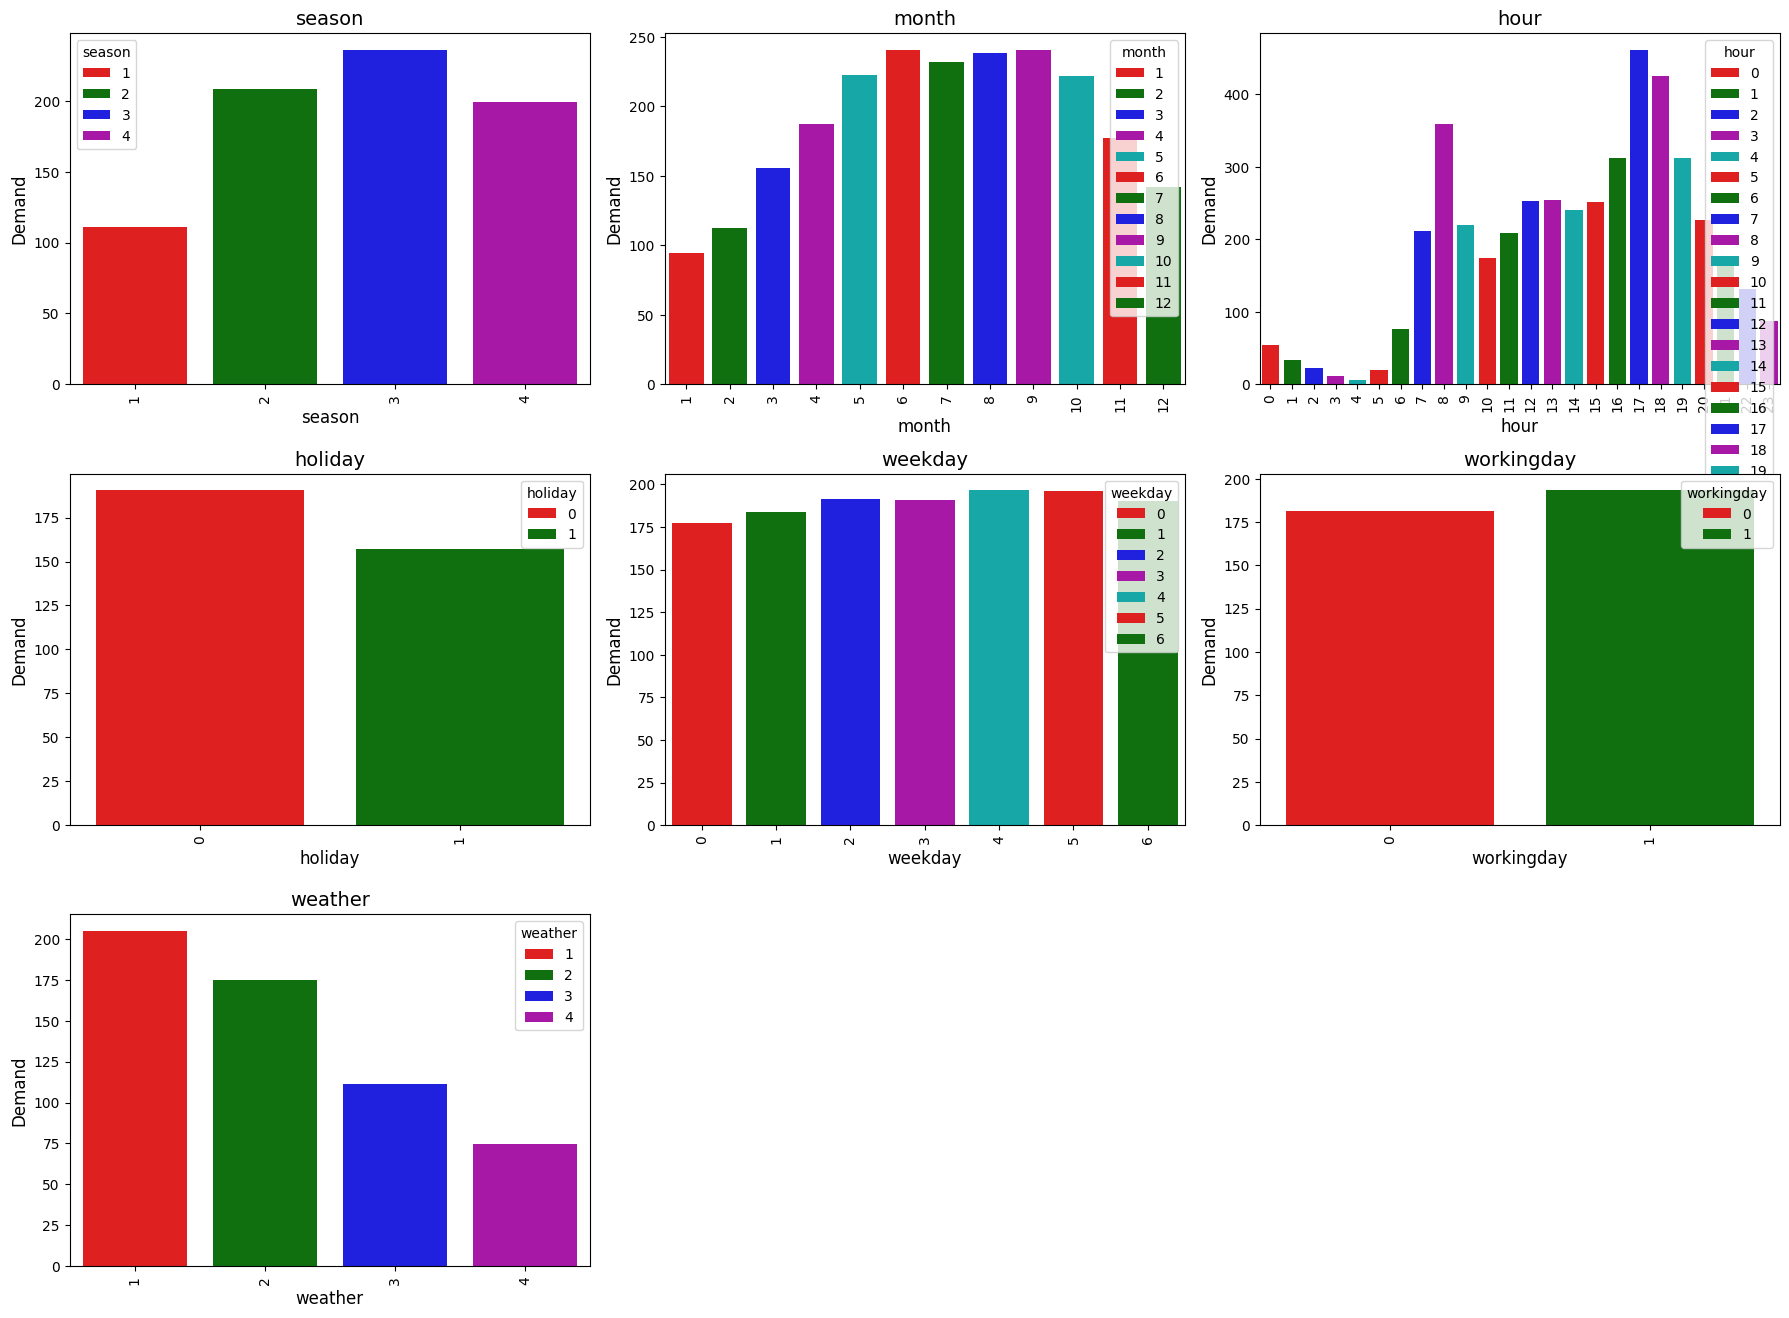

In [638]:
cat_cols = data.select_dtypes(include='category').columns
num_features = len(cat_cols)
n_cols = 3 # You can adjust the number of columns in the grid
n_rows = (num_features + n_cols - 1) // n_cols # Calculate rows needed
colors = ['r', 'g', 'b', 'm', 'c']
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration
i = 0

for feature in cat_cols:
    uniq_vals = data[feature].unique()
    cat_average = data.groupby(feature)[*Y_cols].mean()
    
    # 3. Iterate through each feature and plot its relationship with the target
    ax = axes[i] # Get the current subplot axis

    sns.barplot(data=cat_average, x= feature, y= 'demand',hue=feature, ax=ax, palette=colors)

    ax.set_title(f'{feature}', fontsize=14)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Demand', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    i = i + 1
for j in range(i, len(axes)):
        fig.delaxes(axes[j])
    
plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()    

### Remove columns
- Remove working day and week day column coz there is very less variabliity in demand for these features

In [639]:
cols_to_remove = ['workingday', 'weekday']
data.drop(columns= cols_to_remove, inplace=True)
current_cols = [x for x in X_cols if x not in cols_to_remove]

In [640]:
data.dtypes

season       category
month        category
hour         category
holiday      category
weather      category
temp          float64
humidity      float64
windspeed     float64
demand          int64
dtype: object

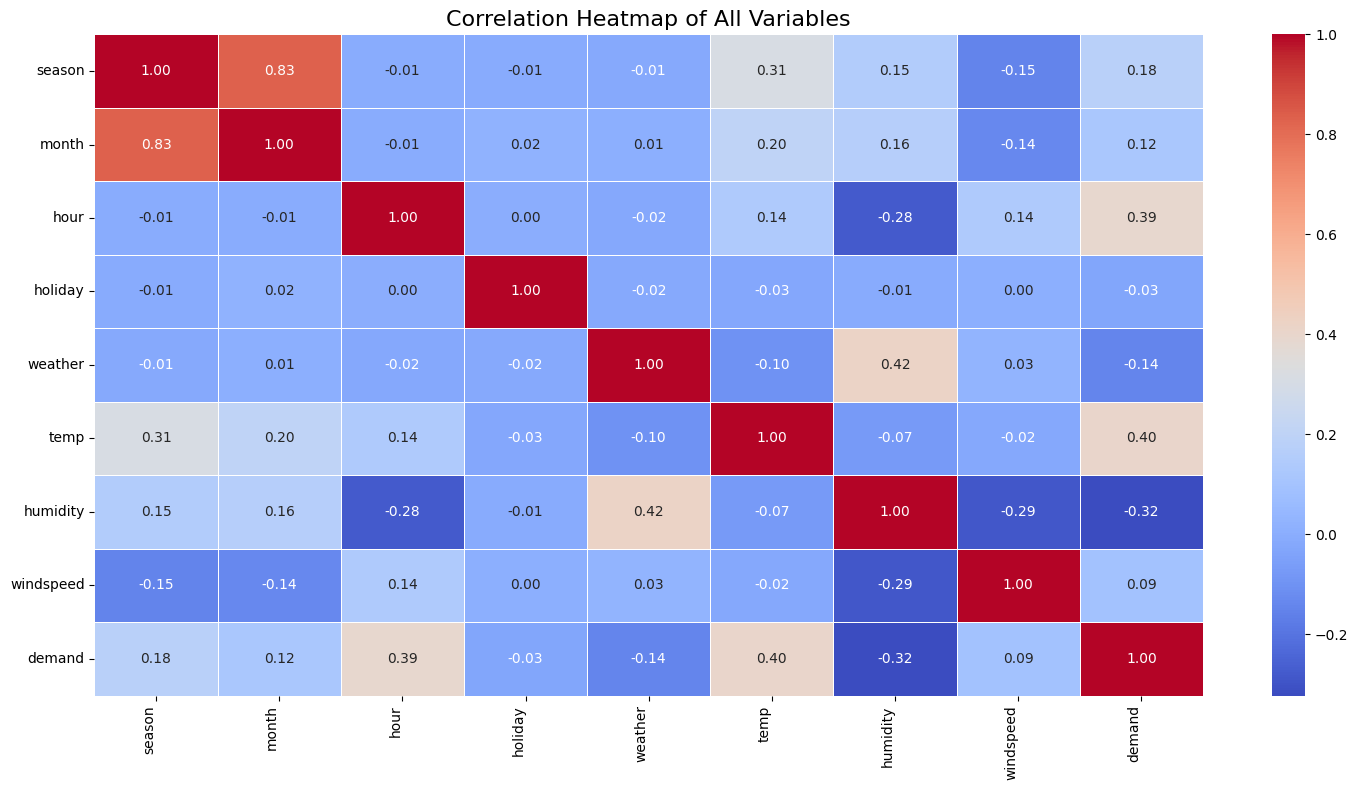

In [641]:
heat_map_viz(data)

### The Target variable Demand does not follow a normal distribution so we need to convert it into a log normalform


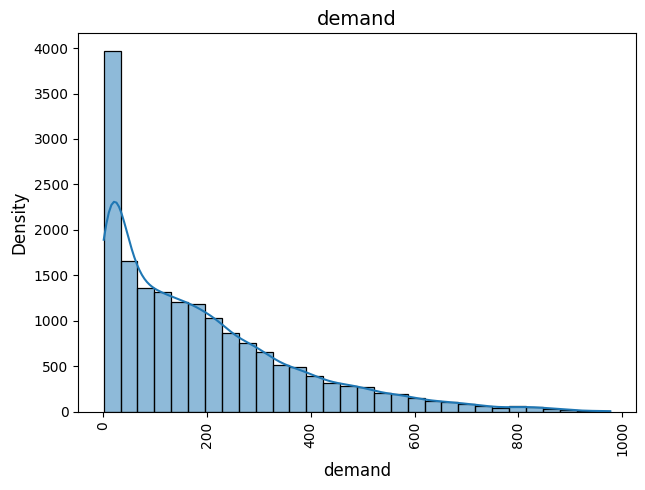

In [642]:
hist_plot_viz(Y_cols, data)

#### Below is the graph after the log normal transformation

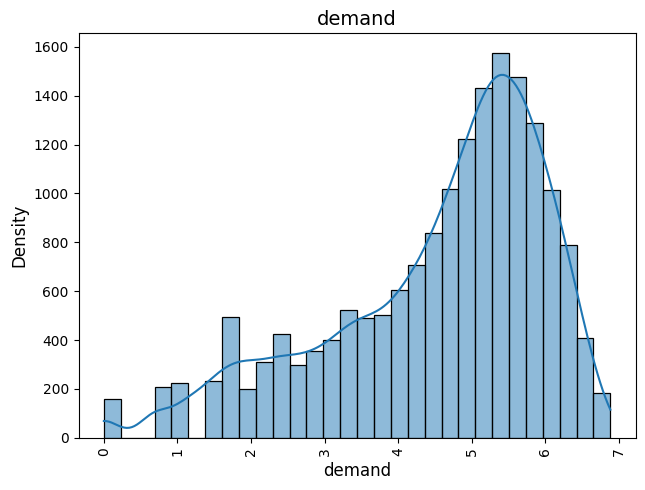

In [643]:
data['demand'] = np.log(data['demand'])
hist_plot_viz(Y_cols, data)

### Remove outliers from the demand column

In [644]:
Q1 = data['demand'].quantile(0.25)
Q3 = data['demand'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR
data = data[(data['demand'] >= lower_bound) & (data['demand'] <= upper_bound)]  

### Test for autocorrelation in the target column

(array([-12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
          1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12]),
 array([0.8793864 , 0.87951267, 0.8797895 , 0.8806706 , 0.88281816,
        0.88769895, 0.89594   , 0.9075407 , 0.923874  , 0.9453945 ,
        0.96914285, 0.9893319 , 1.        , 0.9893318 , 0.96914285,
        0.9453945 , 0.923874  , 0.9075408 , 0.89594   , 0.88769895,
        0.88281816, 0.8806706 , 0.8797895 , 0.87951267, 0.8793864 ],
       dtype=float32),
 <matplotlib.lines.Line2D at 0x127bd1460>)

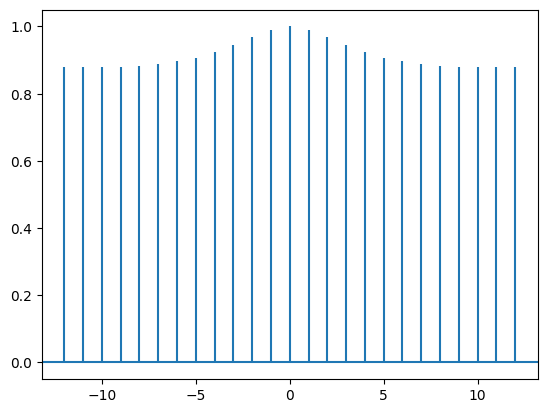

In [645]:
target_df = pd.to_numeric(data['demand'], downcast='float')
plt.acorr(target_df, maxlags=12)

#### Lets correct the autocorrelation using lag

In [646]:
t_1 = data['demand'].shift(+1).to_frame()
t_1.columns = ['t-1']
t_2 = data['demand'].shift(+2).to_frame()
t_2.columns = ['t-2']
t_3 = data['demand'].shift(+3).to_frame()
t_3.columns = ['t-3']

In [647]:
data_lag = pd.concat([data, t_1, t_2, t_3], axis=1)
data_lag.head()

,season,month,hour,holiday,weather,temp,humidity,windspeed,demand,t-1,t-2,t-3
0,1,1,0,0,1,0.24,0.81,0.0,2.772589,NaN,NaN,NaN
1,1,1,1,0,1,0.22,0.80,0.0,3.688879,2.772589,NaN,NaN
2,1,1,2,0,1,0.22,0.80,0.0,3.465736,3.688879,2.772589,NaN
3,1,1,3,0,1,0.24,0.75,0.0,2.564949,3.465736,3.688879,2.772589
4,1,1,4,0,1,0.24,0.75,0.0,0.000000,2.564949,3.465736,3.688879


In [648]:
data_lag.dropna(inplace=True)
data_lag.head()

,season,month,hour,holiday,weather,temp,humidity,windspeed,demand,t-1,t-2,t-3
3,1,1,3,0,1,0.24,0.75,0.0000,2.564949,3.465736,3.688879,2.772589
4,1,1,4,0,1,0.24,0.75,0.0000,0.000000,2.564949,3.465736,3.688879
5,1,1,5,0,2,0.24,0.75,0.0896,0.000000,0.000000,2.564949,3.465736
6,1,1,6,0,1,0.22,0.80,0.0000,0.693147,0.000000,0.000000,2.564949
7,1,1,7,0,1,0.20,0.86,0.0000,1.098612,0.693147,0.000000,0.000000


### Encode categorical variables

In [649]:
data_lag = pd.get_dummies(data_lag, drop_first=True)
data_lag.head()

,temp,humidity,windspeed,demand,t-1,t-2,t-3,season_2,season_3,season_4,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,holiday_1,weather_2,weather_3,weather_4
3,0.24,0.75,0.0000,2.564949,3.465736,3.688879,2.772589,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.24,0.75,0.0000,0.000000,2.564949,3.465736,3.688879,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,0.24,0.75,0.0896,0.000000,0.000000,2.564949,3.465736,False,False,False,...,False,False,False,False,False,False,False,True,False,False
6,0.22,0.80,0.0000,0.693147,0.000000,0.000000,2.564949,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,0.20,0.86,0.0000,1.098612,0.693147,0.000000,0.000000,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Train Test Split

In [650]:
Y = data_lag['demand']
X = data_lag.drop('demand', axis = 1)

In [651]:
train_size = int(0.7 * len(X))
X_train = X.values[0 : train_size]
X_test = X.values[train_size : ]

Y_train = Y.values[0 : train_size]
Y_test = Y.values[train_size : ]

### Fit the linear regression model

In [652]:
model = LinearRegression()
model.fit(X = X_train, y = Y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### R Squared metrics of the model

In [653]:
r2_train = model.score(X = X_train, y = Y_train)
print('r2 train : ', r2_train)
r2_test = model.score(X = X_test, y = Y_test)
print('r2 test : ', r2_test)

r2 train :  0.9196714747989388
r2 test :  0.9285438007534608


In [654]:
# RMSE
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.3814


In [655]:
rmsle_lin = np.sqrt(mean_squared_log_error(np.exp(Y_test), np.exp(y_pred)))
print(f"RMSLE: {rmsle_lin:.4f}")


RMSLE: 0.3566


### Try other models

In [657]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(X_train,Y_train)
    test_pred=clf.predict(X_test)
    rmsle.append(np.sqrt(mean_squared_log_error(np.exp(Y_test), np.exp(test_pred))))
d={'Modelling Algo':model_names,'RMSLE':rmsle}   


In [659]:
model_metrics = pd.DataFrame(d)
model_metrics.loc[len(model_metrics)] = {'Modelling Algo':'Linear regression','RMSLE':rmsle_lin}
model_metrics.sort_values(by='RMSLE')

,Modelling Algo,RMSLE
3,SVR,0.307213
0,RandomForestRegressor,0.321468
2,BaggingRegressor,0.340564
5,Linear regression,0.356575
4,KNeighborsRegressor,0.431799
1,AdaBoostRegressor,0.609220


# Important! learn about VIF